# Load modules and Set constants

In [17]:
import os, cv2, glob
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

In [2]:
WIDTH, HEIGHT = 8, 8

EXPERIMENT_DATA = {
    'name' : 'Trajectory_Clusetring',
    'number' : '30',
    'date' : '07-15-2021',
    'description' : 'Compute Mean Squared Error of similar trajectories\n'
    }

ROOT_DIR = os.path.join('C:\\', 'GitHub', 'Lab_Experiment', 'Trajectory_Clustering')

GEOLIFE_DIR = os.path.join('C:\\', 'Dataset', 'Geolife')
DATA_DIR = os.path.join(GEOLIFE_DIR, 'Bitmap')
LOW_DIMENSION_DIR = os.path.join(GEOLIFE_DIR, 'Low_Dimension')

RESULT_DIR = os.path.join( 'C:\\', 'GitHub', 'Lab_Experiment', 'Results')

os.chdir(RESULT_DIR)
curr_result_name = f"{EXPERIMENT_DATA['name']}_{EXPERIMENT_DATA['number']}_{EXPERIMENT_DATA['date']}_Results"
if (curr_result_name not in os.listdir()):
    os.mkdir(curr_result_name)

CURR_RESULT_DIR = os.path.join(RESULT_DIR, curr_result_name)
os.chdir(CURR_RESULT_DIR)

with open('Description.txt', 'w') as f:
    f.write(EXPERIMENT_DATA['description'])

print(f'ROOT_DIR:          {ROOT_DIR}')
print(f'GEOLIFE_DIR:       {GEOLIFE_DIR}')
print(f'DATA_DIR:          {DATA_DIR}')
print(f'LOW_DIMENSION_DIR: {LOW_DIMENSION_DIR}')
print(f'RESULT_DIR:        {RESULT_DIR}')
print(f'CURR_RESULT_DIR:   {CURR_RESULT_DIR}')

ROOT_DIR:        C:\GitHub\Lab_Experiment\Trajectory_Clustering
GEOLIFE_DIR:     C:\Dataset\Geolife
DATA_DIR:        C:\Dataset\Geolife\Bitmap
RESULT_DIR:      C:\GitHub\Lab_Experiment\Results
CURR_RESULT_DIR: C:\GitHub\Lab_Experiment\Results\Trajectory_Clusetring_30_07-15-2021_Data


# Load Data

In [3]:
os.chdir(DATA_DIR)
print(sorted(glob.glob('*png'))[:10])

['0th data.png', '1000000th data.png', '1000064th data.png', '1000128th data.png', '1000192th data.png', '1000256th data.png', '1000320th data.png', '100032th data.png', '1000384th data.png', '1000448th data.png']


<Figure size 432x288 with 0 Axes>

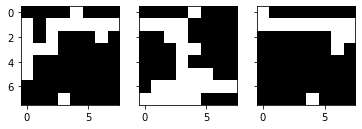

In [4]:
os.chdir(DATA_DIR)
file_names = sorted(glob.glob('*png'))

bitmap_data = [ ]
for file in file_names:
    bitmap_data.append(cv2.imread(file, cv2.IMREAD_GRAYSCALE))

plt.gray()
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True)
ax[0].imshow(bitmap_data[0])
ax[1].imshow(bitmap_data[1])
ax[2].imshow(bitmap_data[2])

plt.show()

In [5]:
X_train = np.array(bitmap_data).astype('float32') / 255.
X_train = np.reshape(X_train, (-1, HEIGHT, WIDTH, 1))

# Load Models

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
os.chdir(os.path.join(ROOT_DIR, 'Models', 'Bitmap'))
encoder = keras.models.load_model('encoder.h5')
decoder =  keras.models.load_model('decoder.h5')
auto_encoder = keras.models.load_model('auto_encoder.h5')

# Get similar data

In [8]:
low_dimension = encoder(X_train)

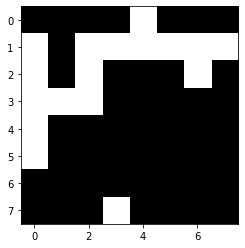

In [9]:
plt.imshow(bitmap_data[0])
plt.savefig('First_Bitmap.png', dpi = 100)
plt.show()

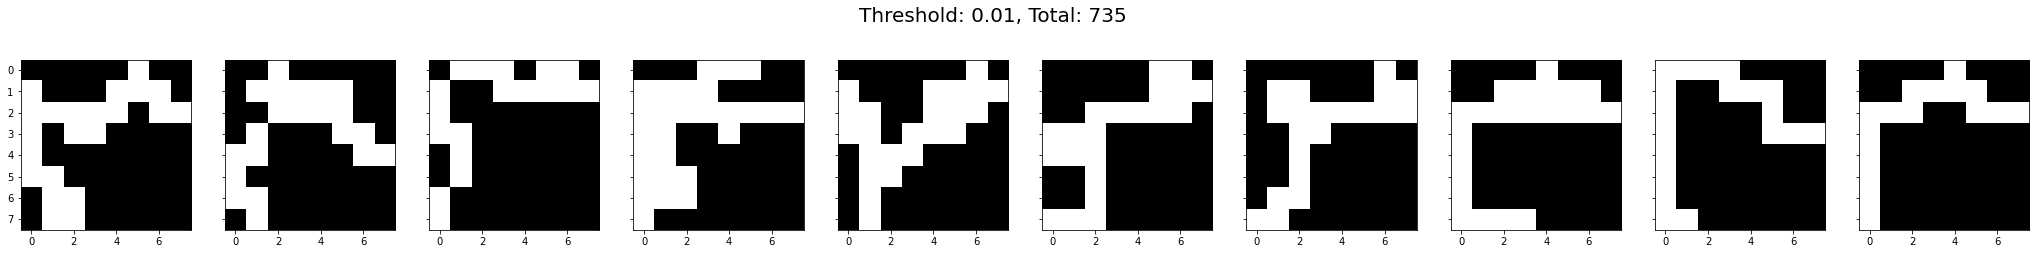

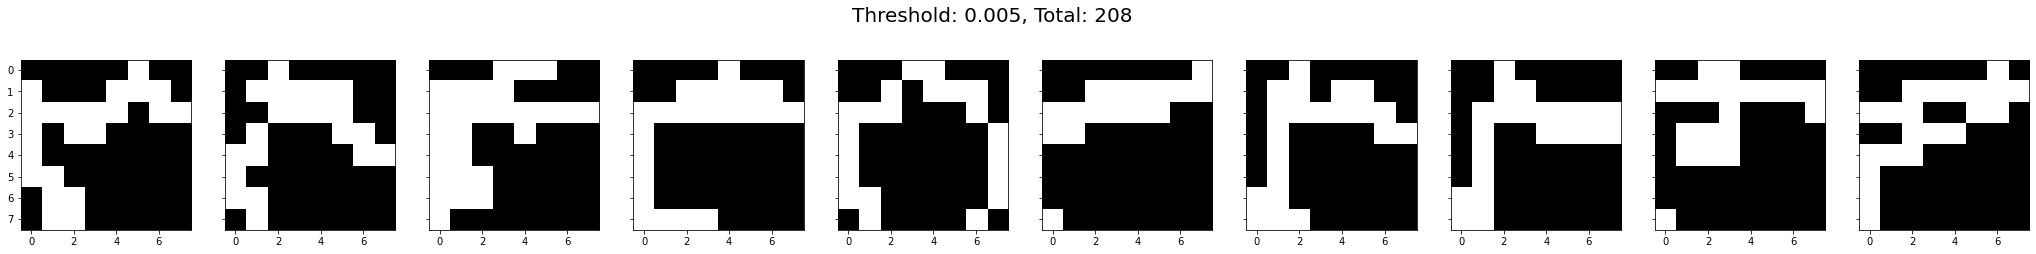

In [10]:
from scipy.spatial import distance

os.chdir(CURR_RESULT_DIR)
thresholds = [0.01, 0.005]
for threshold in thresholds:
    count = 0
    similar_bitmaps = []
    for i in range(1, len(bitmap_data)):
        if (distance.cosine(low_dimension[0], low_dimension[i]) < threshold):
            if (count < 10):
                similar_bitmaps.append(bitmap_data[i])
            count += 1
    
    fig, ax = plt.subplots(1, 10, sharex = True, sharey = True, figsize = (36, 4))
    for i in range(10):
        ax[i].imshow(similar_bitmaps[i])
    plt.suptitle(f'Threshold: {threshold}, Total: {count}', fontsize = 20)
    plt.savefig(f'Result({threshold}).png', dpi = 100)
    plt.show()

In [37]:
import pickle as pkl

In [38]:
def load_low_dimension_data(dir_name: str) -> list:
    low_dimension = []

    os.chdir(os.path.join(LOW_DIMENSION_DIR, dir_name))
    for data in sorted(glob.glob('*data')):
        with open(data, 'rb') as f:
             low_dimension.append(pkl.load(f))
                
    return np.array(low_dimension)

In [41]:
def get_MSE(list1: np.array, list2: np.array) -> float:
    similarities = [ ]
    for low_dim1, low_dim2 in zip(list1, list2):
        similarities.append(distance.cosine(low_dim1, low_dim2))

    return np.square(sum(similarities)) / len(similarities)

In [43]:
os.chdir(LOW_DIMENSION_DIR)
low_dimension_0 = load_low_dimension_data('0th data')

thresholds = [0.01, 0.005]
for threshold in thresholds:
    similar_bitmaps = []
    for i in range(1, len(bitmap_data)):
        if (distance.cosine(low_dimension[0], low_dimension[i]) < threshold):
            os.chdir(LOW_DIMENSION_DIR)
            target_dir_name = file_names[i].split('.')[0]
            target_low_dimension = load_low_dimension_data(target_dir_name)
            
            similar_bitmaps.append([get_MSE(low_dimension_0, target_low_dimension), target_dir_name])
    
    df = pd.DataFrame(similar_bitmaps, columns = ['MSE', 'DataNumber'])

    os.chdir(CURR_RESULT_DIR)
    df.to_csv(f'MSE_RESULT_{threshold}.csv')

In [42]:
get_MSE(low_dimension_0, low_dimension_0)

0.0